# B06.1 DEG in Hippocampal 海马区中的差异基因

- Script Function: Conduct differential analysis and pathway enrichment for the experimental group with sleep deprivation in the hippocampus area and the control group.  
脚本功能：对海马区睡眠剥夺实验组和对照组进行差异分析及通路富集 
- Input: The h5ad files after the segmentation of the hippocampus area of each sample. 
输入：各样本海马区分割后的h5ad
- Output: lists of differentially expressed genes  
输出：差异基因列表

## 0. Package importing 环境导入

In [1]:
import stereo as st
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from stereo.core.ms_data import MSData
from stereo.core.ms_pipeline import slice_generator

## 1. Data importing 数据导入  

In [2]:
areainfo = ['CT1','CT2','CT3','EP1','EP2','EP3']
areas = ["Hippocampal"]
indir = "./processdata"

In [4]:
dataList = []
for i in areainfo:
    for j in areas:
        indata = st.io.read_h5ad(f"{indir}/B05.Lasso/{i}/B05.{i}.{j}.adjusted.cellbin.h5ad")
        dataList.append(indata)

In [5]:
data = MSData(_data_list=dataList)
data.shape

{'0': (10538, 28871),
 '1': (11016, 28807),
 '2': (7394, 28846),
 '3': (13172, 28819),
 '4': (9070, 28750),
 '5': (9812, 28920)}

## 2. 数据整合分析 

In [6]:
data.tl.raw_checkpoint(scope=slice_generator[:], mode='integrate') 
data.tl.normalize_total(scope=slice_generator[:], mode='integrate')
data.tl.log1p(scope=slice_generator[:], mode='integrate')
data.tl.highly_variable_genes(scope=slice_generator[:],mode='integrate',
                                               min_mean=0.0125,max_mean=3,min_disp=0.5,n_top_genes=4000,res_key='highly_variable_genes')
data.tl.scale(scope=slice_generator[:], mode='integrate')
data.tl.pca(scope=slice_generator[:], mode='integrate', use_highly_genes=True, n_pcs=50, res_key='pca')
data.tl.batches_integrate(scope=slice_generator[:],pca_res_key='pca', res_key='pca_integrated')

[2025-02-12 14:13:20][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run raw_checkpoint
[2025-02-12 14:13:21][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run normalize_total
[2025-02-12 14:13:21][Stereo][281856][MainThread][140498220615488][st_pipeline][41][INFO]: start to run normalize_total...
[2025-02-12 14:13:27][Stereo][281856][MainThread][140498220615488][st_pipeline][44][INFO]: normalize_total end, consume time 5.6613s.
[2025-02-12 14:13:27][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run log1p
[2025-02-12 14:13:27][Stereo][281856][MainThread][140498220615488][st_pipeline][41][INFO]: start to run log1p...
[2025-02-12 14:13:27][Stereo][281856][MainThread][140498220615488][st_pipeline][44][INFO]: log1p end, consume time 0.5354s.
[2025-02-12 14:13:27][Stereo][281856][MainThread][140498220615488][ms_pip

In [7]:
data.obs['group'] = np.where(data.obs['batch'].isin(['0', '1', '2']), 'CT', 'EP')

In [8]:
data.tl.find_marker_genes(scope=slice_generator[:],mode='integrate',cluster_res_key='group',method='t_test',use_highly_genes=False,use_raw=True)

[2025-02-12 14:21:46][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run find_marker_genes
[2025-02-12 14:21:46][Stereo][281856][MainThread][140498220615488][st_pipeline][41][INFO]: start to run find_marker_genes...
[2025-02-12 14:21:54][Stereo][281856][MainThread][140498220615488][tool_base][122][INFO]: read group information, grouping by group column.
[2025-02-12 14:21:54][Stereo][281856][MainThread][140498220615488][tool_base][151][INFO]: start to run...
[2025-02-12 14:21:55][Stereo][281856][MainThread][140498220615488][tool_base][153][INFO]: end to run.
[2025-02-12 14:21:55][Stereo][281856][MainThread][140498220615488][st_pipeline][44][INFO]: find_marker_genes end, consume time 8.7165s.


In [9]:
data

ms_data: {'0': (10538, 28871), '1': (11016, 28807), '2': (7394, 28846), '3': (13172, 28819), '4': (9070, 28750), '5': (9812, 28920)}
num_slice: 6
names: ['0', '1', '2', '3', '4', '5']
merged_data: id(140497977591696)
obs: ['batch', 'group']
var: ['means', 'dispersions', 'dispersions_norm', 'highly_variable']
relationship: other
var_type: intersect to 27560
current_mode: integrate
current_scope: scope_[0,1,2,3,4,5]
scopes_data: ['scope_[0,1,2,3,4,5]:id(140497977591696)']
mss: ["scope_[0,1,2,3,4,5]:['highly_variable_genes', 'pca', 'pca_variance_ratio', 'PCs', 'pca_integrated', 'marker_genes']"]

## 3. 差异基因火山图

In [10]:
markergene = data.tl.result["scope_[0,1,2,3,4,5]"]['marker_genes']['EP.vs.rest'].copy(deep=True)

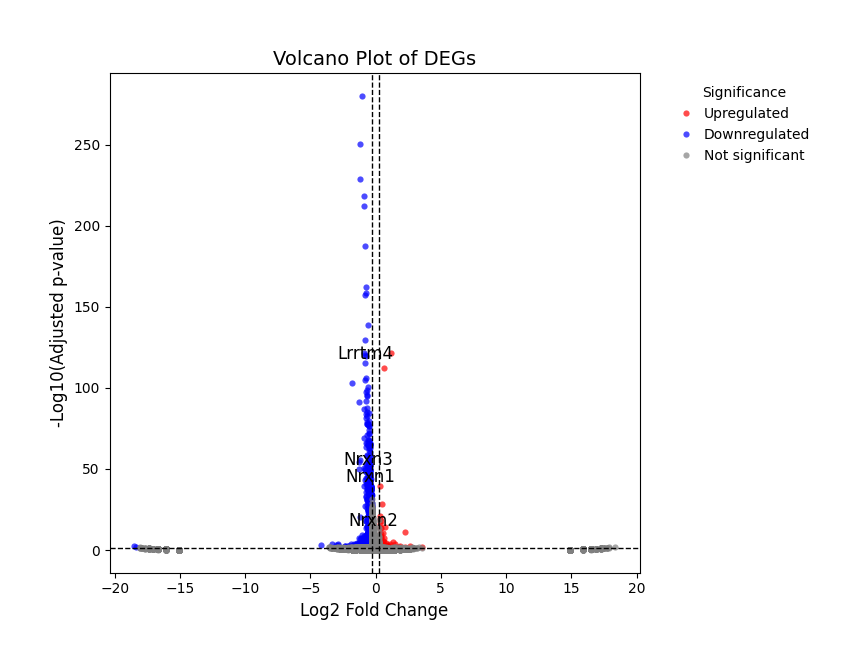

In [11]:
deg_df = markergene.copy(deep=True)

# 假设你的数据框名为 deg_df
# 如果数据是从文件读取的，可以使用以下代码：
# deg_df = pd.read_csv("your_file.csv")

# 添加显著性标记列
deg_df['significance'] = np.where(
    (deg_df['pvalues_adj'] < 0.01) & (deg_df['log2fc'] > 0.3), 'Upregulated',
    np.where(
        (deg_df['pvalues_adj'] < 0.01) & (deg_df['log2fc'] < -0.3), 'Downregulated',
        'Not significant'
    )
)

# 设置颜色映射
colors = {'Upregulated': 'red', 'Downregulated': 'blue', 'Not significant': 'grey'}

# 绘制火山图
plt.figure(figsize=(8, 6))
for significance, color in colors.items():
    subset = deg_df[deg_df['significance'] == significance]
    plt.scatter(subset['log2fc'], -np.log10(subset['pvalues_adj']), 
                color=color, label=significance, alpha=0.7, s=20)

# 添加显著性阈值线
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=1)  # p-value = 0.05
plt.axvline(-0.3, linestyle='--', color='black', linewidth=1)  # log2FC = -1
plt.axvline(0.3, linestyle='--', color='black', linewidth=1)  # log2FC = 1

# 添加标题和标签
plt.title('Volcano Plot of DEGs', fontsize=14)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10(Adjusted p-value)', fontsize=12)
plt.legend(title='Significance', bbox_to_anchor=(1.05, 1), loc='upper left')
# 标记显著基因
significant_genes = deg_df[deg_df['genes'].isin(["Nrxn3", "Nrxn2", "Nrxn1", "Lrrtm4"])]
for i, row in significant_genes.iterrows():
    plt.text(row['log2fc'], -np.log10(row['pvalues_adj']), row['genes'], 
             fontsize=12, ha='center', va='bottom')

# 显示图形
plt.tight_layout()
plt.show()

In [19]:
DEGs = markergene[(abs(markergene['log2fc'])>0.3) & (markergene['pvalues_adj']<0.01)]
DEGs

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
0,23.901733,1.208432e-125,1.448017e-122,1.180534,Pmch,0.092063,0.041143,0.101485
1,22.955943,4.022877e-116,3.959660e-113,0.620398,Hspa5,0.345417,0.257254,0.526830
2,13.643304,2.553980e-42,4.724006e-40,0.348284,Hsp90b1,0.421102,0.362858,0.711799
3,11.622437,3.420480e-31,3.832049e-29,0.472306,Elk1,0.115181,0.088054,0.143040
4,9.943133,2.814509e-23,1.775009e-21,0.320451,Homer1,0.202658,0.169442,0.281275
...,...,...,...,...,...,...,...,...
27555,-49.306266,0.000000e+00,0.000000e+00,-2.742261,Cdk8,0.858208,0.904346,3.820459
27556,-52.970967,0.000000e+00,0.000000e+00,-2.742842,Gphn,0.803550,0.877712,3.093873
27557,-55.731016,0.000000e+00,0.000000e+00,-4.749343,Cmss1,0.948774,0.968841,6.466931
27558,-55.847963,0.000000e+00,0.000000e+00,-4.786019,AY036118,0.965652,0.978651,6.708461


In [20]:
print(list(DEGs['genes']))

['Pmch', 'Hspa5', 'Hsp90b1', 'Elk1', 'Homer1', 'Acpp', 'Tsc22d3', 'Mbp', 'Gm38560', 'Trib2', 'Gjb6', 'Plin4', 'Sdf2l1', 'Gpt2', 'Per2', 'Lpar1', '1700016P03Rik', 'Ugt8a', 'Htr1a', 'Gpr161', 'Cartpt', 'Gm17167', 'Ptgs2', 'Inhbc', 'Plp1', 'Fam83d', 'Fosb', 'Wnt2', 'Tmsb4x', 'F2rl2', 'Tnnt1', 'Serpinh1', 'B4galnt2', 'Gm11290', 'Tstd1', 'Slc47a1', 'Gm10030', 'Hhip', 'Slc27a3', 'Thbs4', 'Alox12b', 'Gm14827', 'Pla2g4b', 'Tent5a', 'Ppp1r3g', 'Hist2h3c1', 'Nphs1', 'Avp', 'Pirt', 'Ccdc34os', 'Gch1', 'Rxfp3', 'Fbln2', 'Pglyrp1', 'Ctla2a', 'Rnase4', 'Klf4', 'Gm19935', 'Emp1', 'Gm15587', 'Igfbpl1', '4833422M21Rik', 'Agxt2', 'Gm39168', 'A230056P14Rik', 'Gm48433', 'D430036J16Rik', 'Sycp2l', 'Zfp775', 'Gm45619', 'Psg16', 'Cntn6', 'Rad9a', 'Prrx1', 'Pipox', 'Lacc1', 'Faap100', 'Cdc14b', 'Gm2694', 'Nlrp2', 'Ofd1', 'Lhpp', '5033430I15Rik', 'Alg9', 'Leng1', 'Blk', 'Gm10482', 'Lrrc6', 'Gpr179', 'Zfp958', 'Cep57', 'Arsj', 'Ushbp1', 'Gm26791', 'Ly6m', 'Gm43951', 'Rnaset2b', 'Iqcm', 'Riiad1', 'Etaa1', 'Pcdhb

### 4. 差异基因富集分析
    我们使用Metascape进行差异基因的通路富集,网址为https://metascape.org/gp/index.html#/main/step1

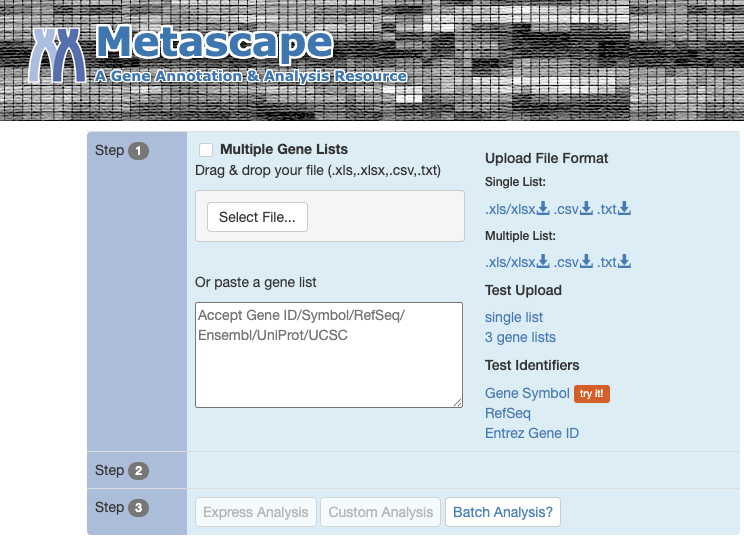

In [32]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import Image
Image("./processdata/metascape_introduction.png")

In [21]:
upDEGs = markergene[(markergene['log2fc']>0.3) & (markergene['pvalues_adj']<0.01)]
upDEGs

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
0,23.901733,1.208432e-125,1.448017e-122,1.180534,Pmch,0.092063,0.041143,0.101485
1,22.955943,4.022877e-116,3.959660e-113,0.620398,Hspa5,0.345417,0.257254,0.526830
2,13.643304,2.553980e-42,4.724006e-40,0.348284,Hsp90b1,0.421102,0.362858,0.711799
3,11.622437,3.420480e-31,3.832049e-29,0.472306,Elk1,0.115181,0.088054,0.143040
4,9.943133,2.814509e-23,1.775009e-21,0.320451,Homer1,0.202658,0.169442,0.281275
...,...,...,...,...,...,...,...,...
157,3.218084,1.291174e-03,7.220930e-03,0.345564,Igfbpl1,0.015567,0.012540,0.018968
162,3.153639,1.613741e-03,8.805127e-03,3.553628,4833422M21Rik,0.000406,0.000035,0.000406
163,3.146789,1.651658e-03,8.990656e-03,1.531499,Agxt2,0.000998,0.000345,0.000998
164,3.140862,1.685511e-03,9.144229e-03,1.800921,Gm39168,0.000811,0.000242,0.000842


In [27]:
downDEGs = markergene[(markergene['log2fc']<-0.3) & (markergene['pvalues_adj']<0.01)]
downDEGs

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
22594,-3.115173,0.001839,0.009876,-0.855150,Gm48433,0.001529,0.002660,0.001529
22597,-3.116153,0.001833,0.009848,-0.788610,D430036J16Rik,0.001934,0.003213,0.002121
22599,-3.117014,0.001828,0.009824,-1.065241,Sycp2l,0.000842,0.001762,0.000842
22601,-3.117900,0.001822,0.009798,-0.403293,Zfp775,0.007955,0.010329,0.008579
22613,-3.124727,0.001781,0.009598,-2.395342,Gm45619,0.000125,0.000622,0.000125
...,...,...,...,...,...,...,...,...
27555,-49.306266,0.000000,0.000000,-2.742261,Cdk8,0.858208,0.904346,3.820459
27556,-52.970967,0.000000,0.000000,-2.742842,Gphn,0.803550,0.877712,3.093873
27557,-55.731016,0.000000,0.000000,-4.749343,Cmss1,0.948774,0.968841,6.466931
27558,-55.847963,0.000000,0.000000,-4.786019,AY036118,0.965652,0.978651,6.708461


#### 4.1 整体差异基因的通路富集结果  
   从富集的结果我们可以看到在海马区的差异基因，主要富集在认知,神经系统中突触的组织，信号传递，粒子传递等。其中我们关注的是synapse organization相关的通路

In [36]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_heatmap_HeatmapSelectedGO_allDEG.pdf",width=1000, height=300)

In [39]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_GO_ColorByCluster_allDEGs.pdf",width=1000, height=400)

#### 4.2 差异基因表达上调的通路富集结果  
   从富集的结果我们可以看到在表达上调的基因富集通路中有关于GO:0033555 - Multicellular organismal response to stress，以及GO:0007218 - Neuropeptide signaling pathway等通路的富集。

In [22]:
print(list(upDEGs['genes']))

['Pmch', 'Hspa5', 'Hsp90b1', 'Elk1', 'Homer1', 'Acpp', 'Tsc22d3', 'Mbp', 'Gm38560', 'Trib2', 'Gjb6', 'Plin4', 'Sdf2l1', 'Gpt2', 'Per2', 'Lpar1', '1700016P03Rik', 'Ugt8a', 'Htr1a', 'Gpr161', 'Cartpt', 'Gm17167', 'Ptgs2', 'Inhbc', 'Plp1', 'Fam83d', 'Fosb', 'Wnt2', 'Tmsb4x', 'F2rl2', 'Tnnt1', 'Serpinh1', 'B4galnt2', 'Gm11290', 'Tstd1', 'Slc47a1', 'Gm10030', 'Hhip', 'Slc27a3', 'Thbs4', 'Alox12b', 'Gm14827', 'Pla2g4b', 'Tent5a', 'Ppp1r3g', 'Hist2h3c1', 'Nphs1', 'Avp', 'Pirt', 'Ccdc34os', 'Gch1', 'Rxfp3', 'Fbln2', 'Pglyrp1', 'Ctla2a', 'Rnase4', 'Klf4', 'Gm19935', 'Emp1', 'Gm15587', 'Igfbpl1', '4833422M21Rik', 'Agxt2', 'Gm39168', 'A230056P14Rik']


In [40]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_heatmap_HeatmapSelectedGO_upDEGs.pdf",width=1000, height=300)

In [41]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_GO_ColorByCluster_upDEGs.pdf",width=1000, height=400)

### 4.3 差异基因表达下调的通路富集

In [29]:
print(list(downDEGs['genes']))

['Gm48433', 'D430036J16Rik', 'Sycp2l', 'Zfp775', 'Gm45619', 'Psg16', 'Cntn6', 'Rad9a', 'Prrx1', 'Pipox', 'Lacc1', 'Faap100', 'Cdc14b', 'Gm2694', 'Nlrp2', 'Ofd1', 'Lhpp', '5033430I15Rik', 'Alg9', 'Leng1', 'Blk', 'Gm10482', 'Lrrc6', 'Gpr179', 'Zfp958', 'Cep57', 'Arsj', 'Ushbp1', 'Gm26791', 'Ly6m', 'Gm43951', 'Rnaset2b', 'Iqcm', 'Riiad1', 'Etaa1', 'Pcdhb11', 'Gsap', 'Gm45904', 'Pard6g', 'Gm40660', 'Gm29100', 'Arhgap6', 'Frmpd3', 'Uvssa', 'Zfp942', 'Gm48623', 'Gnb4', 'Cox15', 'Zfp458', 'Fgr', 'Rwdd2b', 'Tmlhe', 'Adgrf5', 'Gm29865', 'Mzf1', 'Eda', 'Timeless', 'Itgbl1', 'Sugct', 'Stac', 'Adgrg2', 'P3h2', 'Igtp', 'Gm34933', 'Gm20275', 'Gm42456', 'A530013C23Rik', 'Nudt12', 'Spice1', 'Gm2912', 'Adamtsl1', 'Gm41077', 'Atad5', 'Fosl1', 'P2rx7', 'Zkscan2', 'Gm14443', '9430041J12Rik', 'Prdx4', 'Tmem229b', 'Snhg16', 'Pcdhb14', 'Slamf9', 'A730082K24Rik', 'Slc16a8', 'Ankrd63', 'Tti1', 'Olfr138', 'Suclg2', 'Gm10687', 'Gm34655', 'Trim5', '6430710C18Rik', '4930445N06Rik', 'Gm15688', 'Klhl11', 'Slc2a4', '

In [44]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_heatmap_HeatmapSelectedGO_downDEGs.pdf",width=1000, height=300)

In [46]:
#Note: This code is only for demonstrating how to use Metascape. Please do not execute it.
#注意本代码只是为了演示如何使用Metascape，请勿运行。
from IPython.display import IFrame
IFrame("./processdata/Enrichment_GO_ColorByCluster_downDEGs.pdf",width=1000, height=400)

针对富集LogP最高的通路GO:0050808 synapse organization，我们希望能查看其具体的基因差异表达表现

In [49]:
synapse_organization = 'Ache,Chrna7,Actb,Ctnna2,Cdh6,Cfl1,Drd2,Epha4,Epha5,Gabra4,Gabrb2,Gabrb3,Gabrg3,Gpc4,Grid2,Grin2a,Large1,Map1b,Ctnnd2,Nrg3,Nrp1,Nrxn1,Nrxn3,Ntrk3,Pak3,Palm,Pdgfb,Pfn2,Pten,Ptprd,Rph3a,Nptn,Sema3a,Sez6,Snca,Sptbn2,Syn1,Tuba1a,Dlg2,Tenm3,Nbea,Pclo,Syn3,Hip1r,Magi2,Mpp2,Ccdc39,Cntnap1,Cntn6,Clstn2,Cntnap2,Dock7,Kirrel3,Plxnd1,Ppfia4,Filip1,Actr3,Myh10,Ntng1,Tmem108,Trem2,Sncb,Chd4,Grm5,Gabra5,Slc8a2,Slc8a3,Rims1,Rims2,Ntng2,Nlgn1,Adgrb3,Nrg1,C1ql2,Itpka,Igsf21,Sdk2,Lrfn5,Syngap1,Lrrc4c,Lrrtm4,Ppp1r9a,Plxna4,Cntn5,Slitrk2,Cnksr2,Gphn,Robo2,Lrrc4b,Adgrl3,Ppfia2,Csmd2,Il1rapl1,Frmpd4,Kalrn,Arhgap6,Cdh11,Cdh8,Epb41l3,Fer,Smad3,Nf2,Numb,Plec,Ptprk,Ptpro,Sorbs1,Thy1,Cgn,Cldn34c1,Lims1,Cdh12,Peak1,Cdh18,Ajm1'
synapse_organization = synapse_organization.split(',')
synapse_organization = markergene[markergene['genes'].isin(synapse_organization)]
synapse_organization

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
22616,-3.126418,1.770380e-03,9.548272e-03,-0.321615,Cntn6,0.013072,0.015856,0.014039
22723,-3.182821,1.459279e-03,8.045155e-03,-0.373516,Arhgap6,0.010451,0.012643,0.010950
22991,-3.323352,8.899964e-04,5.201081e-03,-0.483106,Drd2,0.006177,0.008291,0.006583
23161,-3.405091,6.619004e-04,4.018941e-03,-0.527973,Ntng2,0.005522,0.007393,0.005709
23481,-3.579020,3.451690e-04,2.263888e-03,-0.349221,Ache,0.013696,0.016927,0.014101
...,...,...,...,...,...,...,...,...
27520,-19.906380,7.193560e-88,4.720345e-85,-0.520573,Kalrn,0.488488,0.538897,0.901448
27525,-20.774981,1.769796e-95,1.318259e-92,-0.729912,Nrg3,0.246958,0.314633,0.379422
27534,-23.300298,1.959488e-119,2.000129e-116,-0.818894,Lrrtm4,0.203220,0.265649,0.282835
27542,-27.595933,1.701270e-166,2.604833e-163,-0.695890,Peak1,0.446996,0.531367,0.753354


我们关注Lrrtm4和Nrxn3基因的表达差异，其中Lrrtm4的log2fc为-0.818894，并且主要在DG区域表达。

突触后神经胶蛋白和LRRTM与突触前神经毒素的复合物对兴奋性突触的发展有广泛的贡献，这些基因家族中的突变增加了患精神病的风险。我们发现LRRTM4具有独特的突触前结合伙伴，硫酸乙酰肝素蛋白聚糖（HSPGs）。需要HSPG介导LRRTM4的突触活性。 LRRTM4在大脑中显示高度选择性的表达。在海马中，我们在齿状回颗粒细胞的兴奋性突触后位点特异性检测到LRRTM4。 LRRTM4- /齿状回颗粒细胞，而不是CA1锥体细胞，表现出兴奋性突触密度和功能降低。此外，LRRTM4- /齿状回颗粒细胞显示出活性调节的AMPA受体运输受损。

In [54]:
HSPGs = 'Gpc1,Gpc2,Gpc3,Gpc4,Gpc5'
HSPGs = HSPGs.split(',')
HSPGs = markergene[markergene['genes'].isin(HSPGs)]
HSPGs

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
227,2.693542,7.071656e-03,3.140426e-02,0.374292,Gpc2,0.008985,0.006874,0.010108
3745,0.548654,5.832451e-01,7.763081e-01,0.020879,Gpc1,0.134305,0.129163,0.180383
7385,-0.069873,9.442946e-01,1.000000e+00,-0.009092,Gpc3,0.008579,0.008982,0.009234
26281,-6.463205,1.033504e-10,2.191028e-09,-0.522359,Gpc4,0.020122,0.027808,0.022088
27045,-9.299544,1.464005e-20,7.729499e-19,-0.542217,Gpc5,0.088912,0.109092,0.123573


[2025-02-13 14:38:59][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

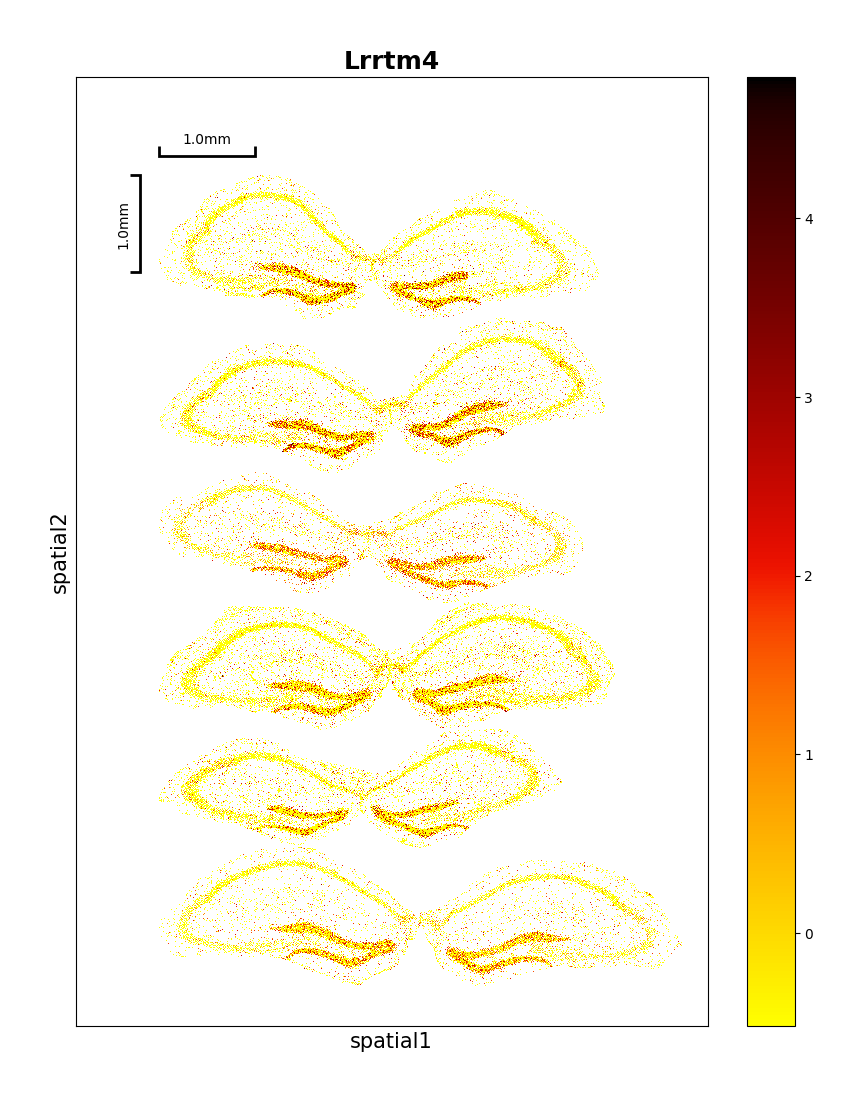

In [60]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Lrrtm4")

[2025-02-13 14:01:28][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

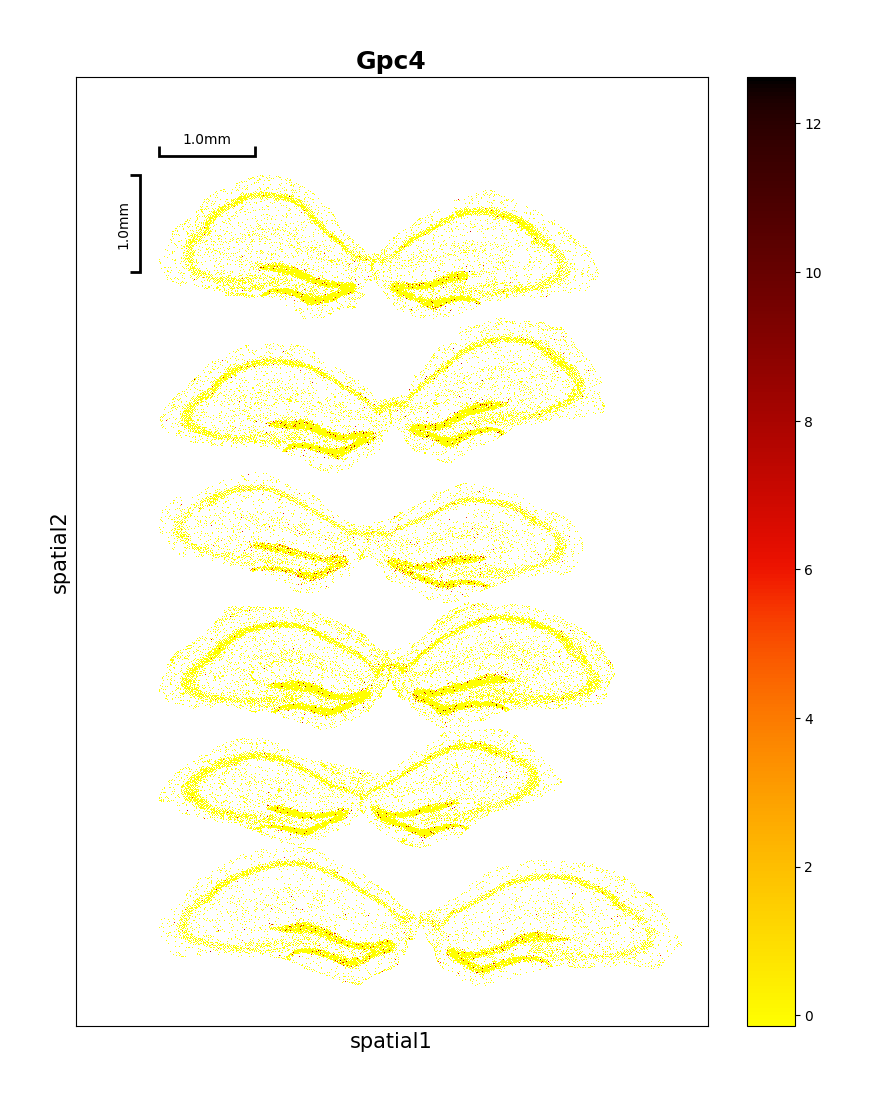

In [58]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Gpc4")

[2025-02-19 14:27:47][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

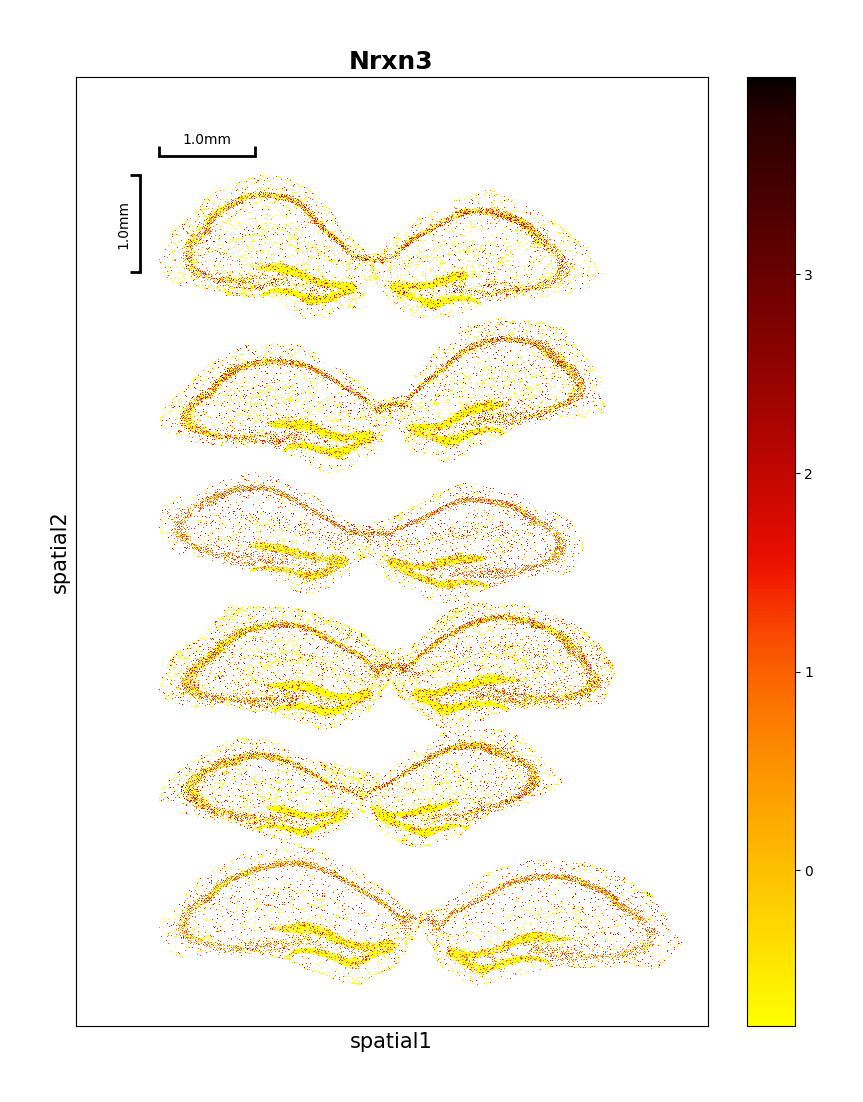

In [67]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Nrxn3")

[2025-02-19 14:20:30][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

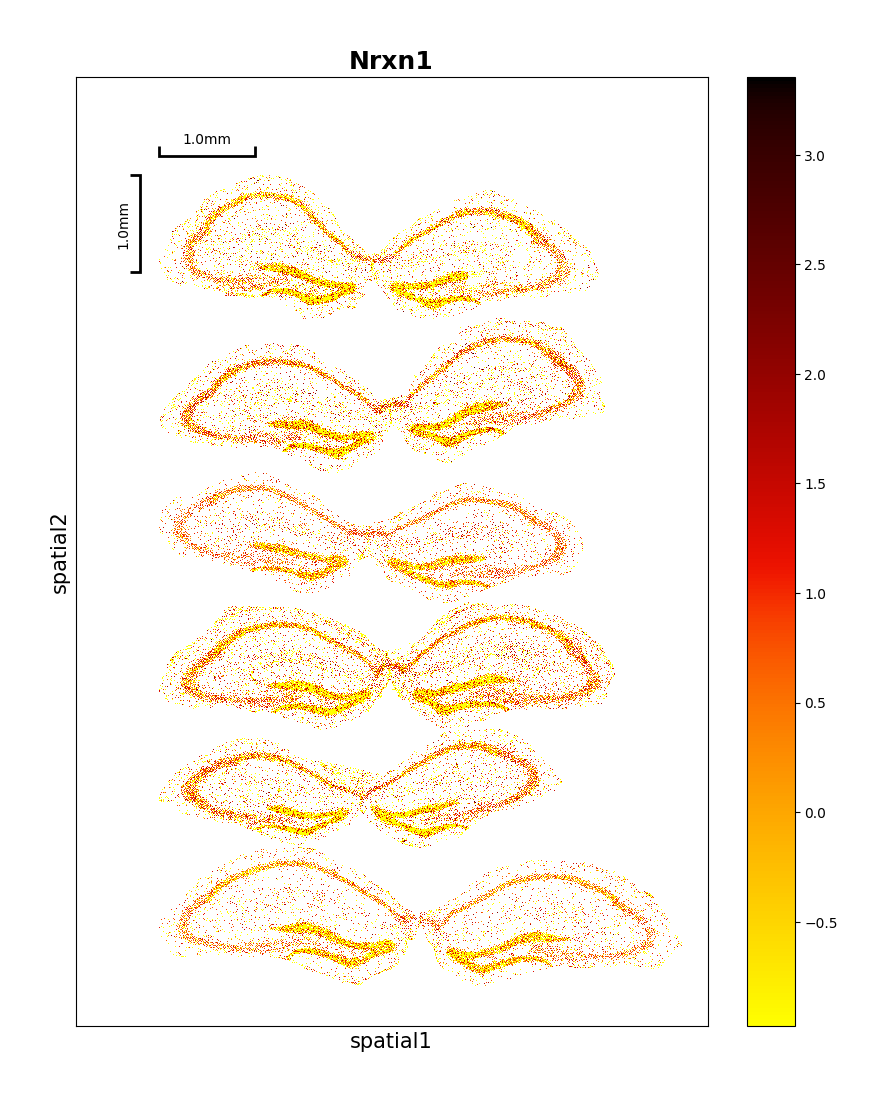

In [63]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Nrxn1")

[2025-02-19 15:28:20][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

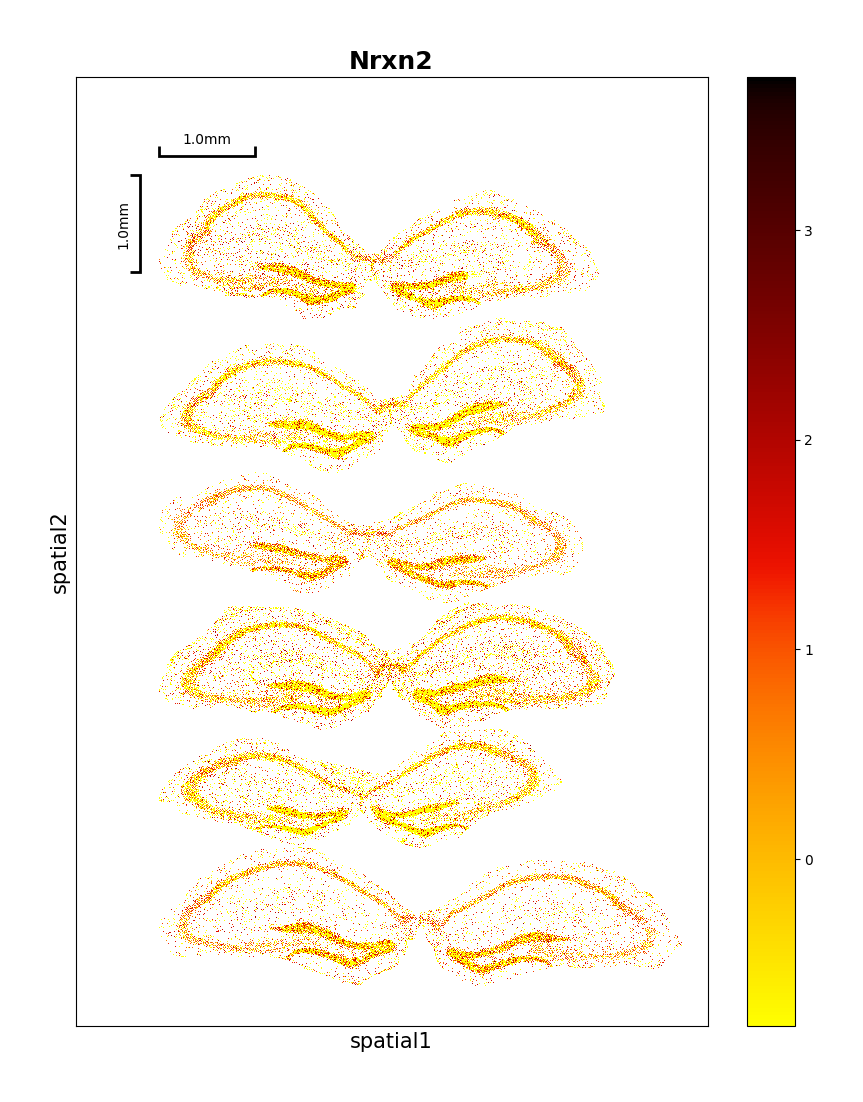

In [80]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Nrxn2")

[2025-02-19 15:27:58][Stereo][281856][MainThread][140498220615488][ms_pipeline][123][INFO]: data_obj(idx=0) in ms_data start to run spatial_scatter_by_gene


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

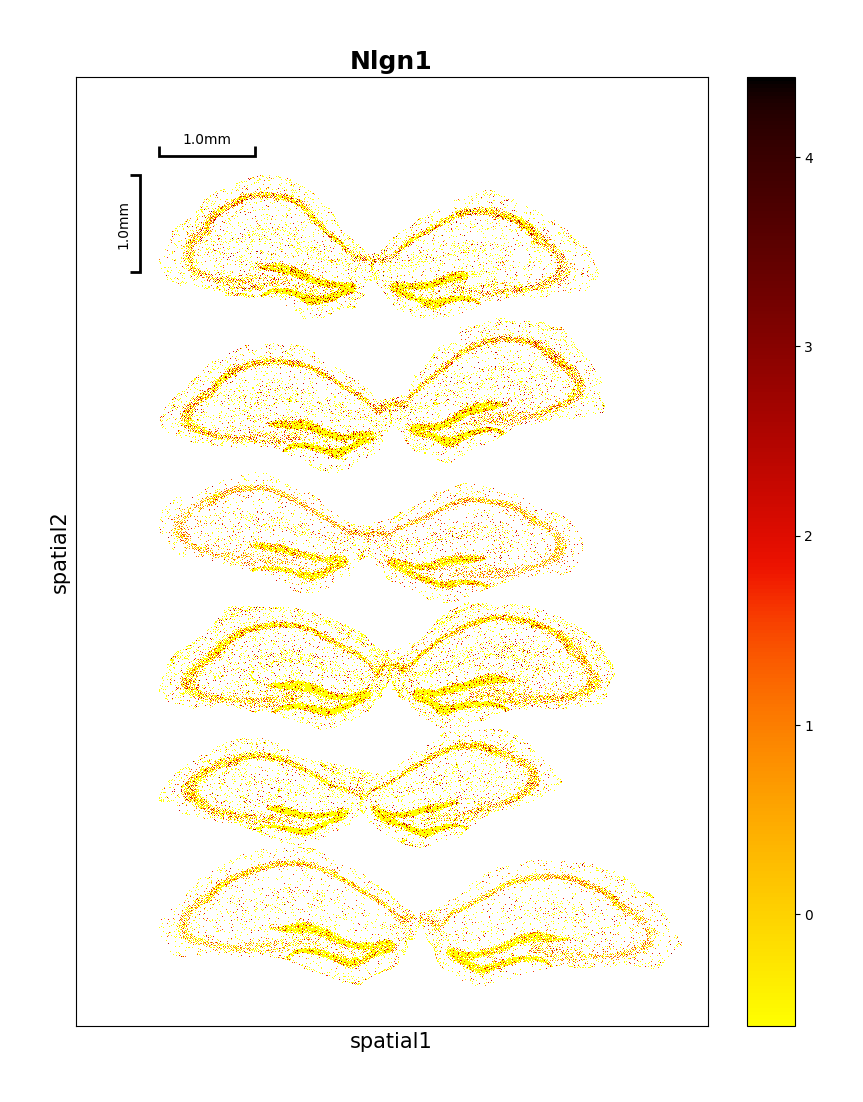

In [79]:
data.plt.spatial_scatter_by_gene(scope=slice_generator[:],mode='integrate',reorganize_coordinate=1,dot_size=0.5,gene_name="Nlgn1")

In [78]:
HSPGs = 'Clstn1,Clstn3,Nrxn1,Nrxn2,Nrxn3,Nlgn1,Nlgn2,Nlgn3,Adgrl1'
HSPGs = HSPGs.split(',')
HSPGs = markergene[markergene['genes'].isin(HSPGs)]
HSPGs

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count
11133,-0.638854,5.229201e-01,7.241093e-01,-0.018257,Clstn3,0.287515,0.278845,0.429993
22897,-3.275835,1.054102e-03,6.035957e-03,-0.128691,Nlgn3,0.101329,0.107192,0.116023
25201,-4.873902,1.096991e-06,1.254485e-05,-0.186634,Nlgn2,0.102733,0.112132,0.115274
26482,-6.932353,4.181766e-12,1.052506e-10,-0.181817,Clstn1,0.367006,0.380441,0.579990
26697,-7.642851,2.156580e-14,6.777120e-13,-0.191028,Nrxn2,0.402664,0.422309,0.646815
27371,-12.755948,3.248776e-37,4.663347e-35,-0.372858,Adgrl1,0.205341,0.237460,0.259718
27412,-13.629695,3.110664e-42,5.677477e-40,-0.396155,Nrxn1,0.506364,0.528361,1.011761
27465,-15.373252,3.207058e-53,9.112013e-51,-0.563748,Nrxn3,0.395208,0.416816,0.811412
27514,-19.135760,2.408638e-81,1.382960e-78,-0.628291,Nlgn1,0.253822,0.308622,0.375741


In [69]:
test = synapse_organization.copy(deep=True)

In [71]:
test['diff'] = test['pct_rest'] - test['pct']

In [76]:
test.sort_values("diff").tail(20)

,scores,pvalues,pvalues_adj,log2fc,genes,pct,pct_rest,mean_count,diff
27438,-14.360868,1.107231e-46,2.460909e-44,-0.474206,Ntrk3,0.163724,0.196974,0.202908,0.033250
27389,-13.240648,5.854229e-40,9.272561e-38,-0.372015,Ptprd,0.297436,0.330973,0.429369,0.033537
27433,-14.317055,2.075086e-46,4.433285e-44,-0.538150,Lrfn5,0.124883,0.158837,0.153616,0.033954
27383,-13.082385,4.729366e-39,7.241184e-37,-0.454542,Sncb,0.125101,0.159286,0.146628,0.034184
27431,-14.218126,8.514387e-46,1.791271e-43,-0.465684,Magi2,0.221314,0.259016,0.313097,0.037702
27408,-13.563964,7.603873e-42,1.352018e-39,-0.346654,Cfl1,0.376926,0.414675,0.585980,0.037748
27469,-15.660577,3.744054e-55,1.109528e-52,-0.570890,Cntnap2,0.228489,0.267341,0.356523,0.038852
27470,-15.669799,3.205936e-55,9.603869e-53,-0.554301,Robo2,0.130686,0.170616,0.160167,0.039931
27456,-15.106102,1.866551e-51,4.853034e-49,-0.448325,Il1rapl1,0.215387,0.257600,0.275379,0.042213
27501,-17.762058,2.179068e-70,9.845100e-68,-0.495333,Epha4,0.325576,0.370457,0.518219,0.044882
